In [7]:
import sys
sys.path.append("..")  # Ensure ml/ is in the path

import numpy as np
import pandas as pd
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective
from ml.simulation import simulate_draft, load_default_weights
from ml.weights import unpack_weights, college_features, noncollege_features

In [2]:
# Search spaces for both college and non-college weights
college_dim = len(college_features) * 3
noncollege_dim = len(noncollege_features) * 3

college_space = [Real(0.0, 1.0, name=f'cw{i}') for i in range(college_dim)]
noncollege_space = [Real(0.0, 1.0, name=f'ncw{i}') for i in range(noncollege_dim)]

# Combine
search_space = college_space + noncollege_space

In [3]:
@use_named_args(college_space)
def college_objective(**params):
    college_array = np.array([params[f'cw{i}'] for i in range(college_dim)])
    college_w = unpack_weights(college_array, is_college=True)

    # Load default non-college weights
    _, noncollege_w = load_default_weights()

    sim_df, accuracy, _ = simulate_draft(
        year=2024,
        composite_weight=0.2,
        plot_distribution=False,
        college_weights=college_w,
        noncollege_weights=noncollege_w
    )
    return -accuracy

@use_named_args(noncollege_space)
def noncollege_objective(**params):
    noncollege_array = np.array([params[f'ncw{i}'] for i in range(noncollege_dim)])
    noncollege_w = unpack_weights(noncollege_array, is_college=False)

    # Load default college weights
    college_w, _ = load_default_weights()

    sim_df, accuracy, _ = simulate_draft(
        year=2024,
        composite_weight=0.2,
        plot_distribution=False,
        college_weights=college_w,
        noncollege_weights=noncollege_w
    )
    return -accuracy

In [4]:
college_result = gp_minimize(
    func=college_objective,
    dimensions=college_space,
    n_calls=30,
    random_state=42,
    verbose=True
)

noncollege_result = gp_minimize(
    func=noncollege_objective,
    dimensions=noncollege_space,
    n_calls=30,
    random_state=42,
    verbose=True
)

Iteration No: 1 started. Evaluating function at random point.
✅ Draft Accuracy (Team Match): 0.00%
🎯 Lottery Hit Rate: 14.29%
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1010
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 2 started. Evaluating function at random point.
✅ Draft Accuracy (Team Match): 0.00%
🎯 Lottery Hit Rate: 14.29%
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0685
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 3 started. Evaluating function at random point.
✅ Draft Accuracy (Team Match): 0.00%
🎯 Lottery Hit Rate: 14.29%
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0698
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 4 started. Evaluating function at random point.
✅ Draft Accuracy (Team Match): 0.00%
🎯 Lottery Hit Rate: 14.29%
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0694
Function value obtaine

In [5]:
# Save best weights to .npy files
np.save("best_college_weights.npy", college_result.x)
np.save("best_noncollege_weights.npy", noncollege_result.x)

print("✅ Saved best weights to disk.")

✅ Saved best weights to disk.


📈 College Weight Convergence


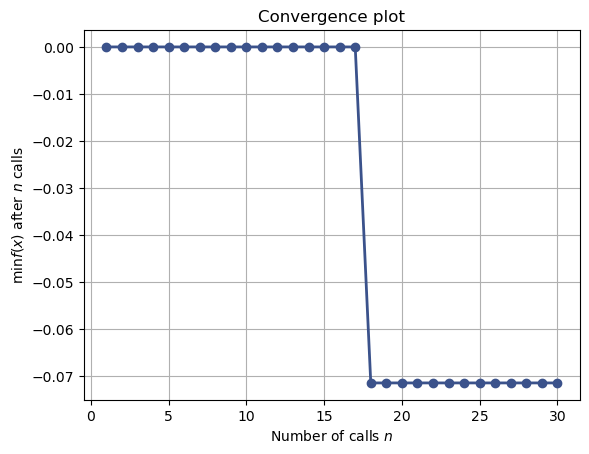

📈 Non-College Weight Convergence


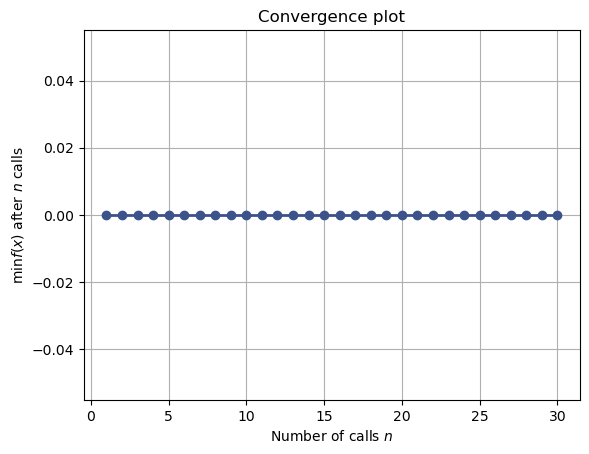

In [6]:
# --- Convergence Plots ---
import matplotlib.pyplot as plt

print("📈 College Weight Convergence")
plot_convergence(college_result)
plt.show()

print("📈 Non-College Weight Convergence")
plot_convergence(noncollege_result)
plt.show()

In [12]:
training_years = [2020, 2021, 2022, 2023, 2024]
results_log = []

def make_college_objective(y):
        @use_named_args(college_space)
        def obj(**params):
            college_array = np.array([params[f'cw{i}'] for i in range(college_dim)])
            college_w = unpack_weights(college_array, is_college=True)
            _, noncollege_w = load_default_weights()

            _, acc, lottery = simulate_draft(
                year=y,
                composite_weight=0.2,
                plot_distribution=False,
                college_weights=college_w,
                noncollege_weights=noncollege_w
            )
            return -acc
        return obj

def make_noncollege_objective(y):
    @use_named_args(noncollege_space)
    def obj(**params):
        noncollege_array = np.array([params[f'ncw{i}'] for i in range(noncollege_dim)])
        noncollege_w = unpack_weights(noncollege_array, is_college=False)
        college_w, _ = load_default_weights()

        _, acc, lottery = simulate_draft(
            year=y,
            composite_weight=0.2,
            plot_distribution=False,
            college_weights=college_w,
            noncollege_weights=noncollege_w
        )
        return -acc
    return obj

for year in training_years:
    print(f"\n🚀 Optimizing for year {year}...\n")

    college_result = gp_minimize(
        func=make_college_objective(year),
        dimensions=college_space,
        n_calls=50,
        random_state=42,
        verbose=True
    )
    np.save(f"../weights/college_weights_{year}.npy", college_result.x)

    noncollege_result = gp_minimize(
        func=make_noncollege_objective(year),
        dimensions=noncollege_space,
        n_calls=50,
        random_state=42,
        verbose=True
    )
    np.save(f"../weights/noncollege_weights_{year}.npy", noncollege_result.x)

    # Run final simulation to log performance
    college_w = unpack_weights(college_result.x, is_college=True)
    noncollege_w = unpack_weights(noncollege_result.x, is_college=False)
    _, acc, lottery = simulate_draft(
        year=year,
        composite_weight=0.2,
        plot_distribution=False,
        college_weights=college_w,
        noncollege_weights=noncollege_w
    )

    results_log.append({
        "year": year,
        "team_accuracy": acc,
        "lottery_accuracy": lottery
    })


🚀 Optimizing for year 2020...

Iteration No: 1 started. Evaluating function at random point.
✅ Draft Accuracy (Team Match): 0.00%
🎯 Lottery Hit Rate: 14.29%
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1701
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 2 started. Evaluating function at random point.
✅ Draft Accuracy (Team Match): 0.00%
🎯 Lottery Hit Rate: 14.29%
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0697
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 3 started. Evaluating function at random point.
✅ Draft Accuracy (Team Match): 7.14%
🎯 Lottery Hit Rate: 14.29%
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0722
Function value obtained: -0.0714
Current minimum: -0.0714
Iteration No: 4 started. Evaluating function at random point.
✅ Draft Accuracy (Team Match): 0.00%
🎯 Lottery Hit Rate: 14.29%
Iteration No: 4 ended. Evaluation done at random point.
Time take

In [15]:
import datetime

now = datetime.datetime.now().strftime("%Y%m%d_%H%M")
log_df = pd.DataFrame(results_log)
log_df.to_csv(f"../logs/training_logs_{now}.csv", index=False)
print("📊 Training logs saved to training_logs.csv")

📊 Training logs saved to training_logs.csv


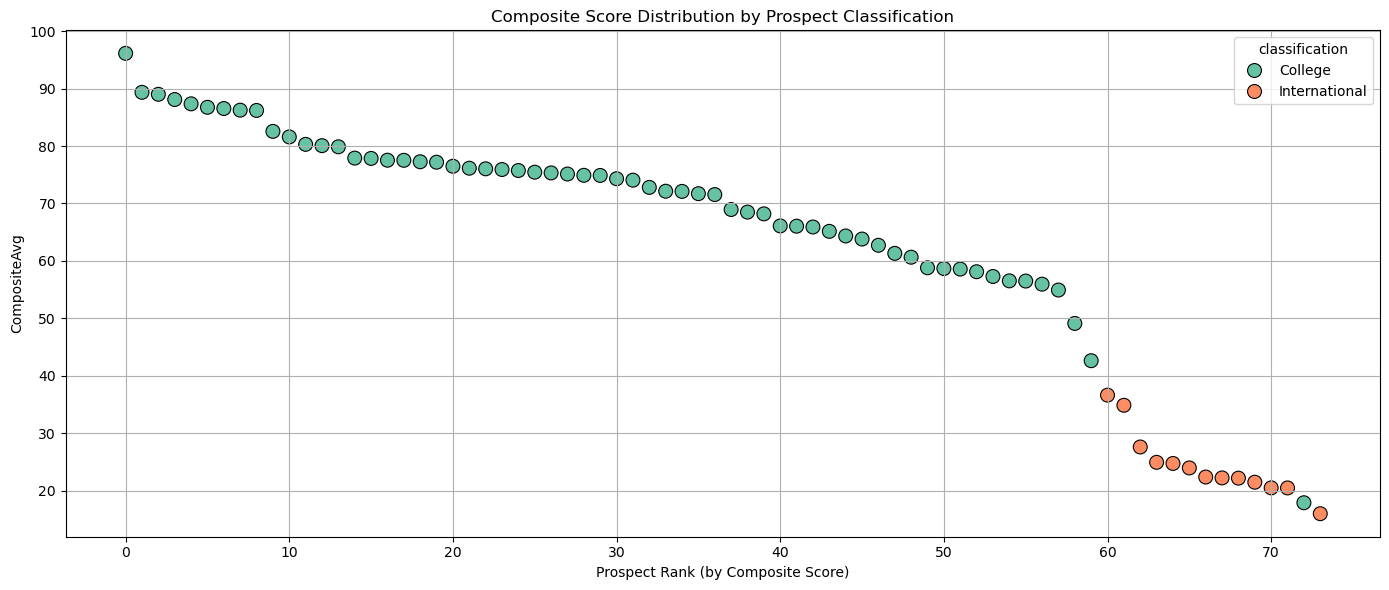

✅ Draft Accuracy (Team Match): 0.00%
🎯 Lottery Hit Rate: 21.43%


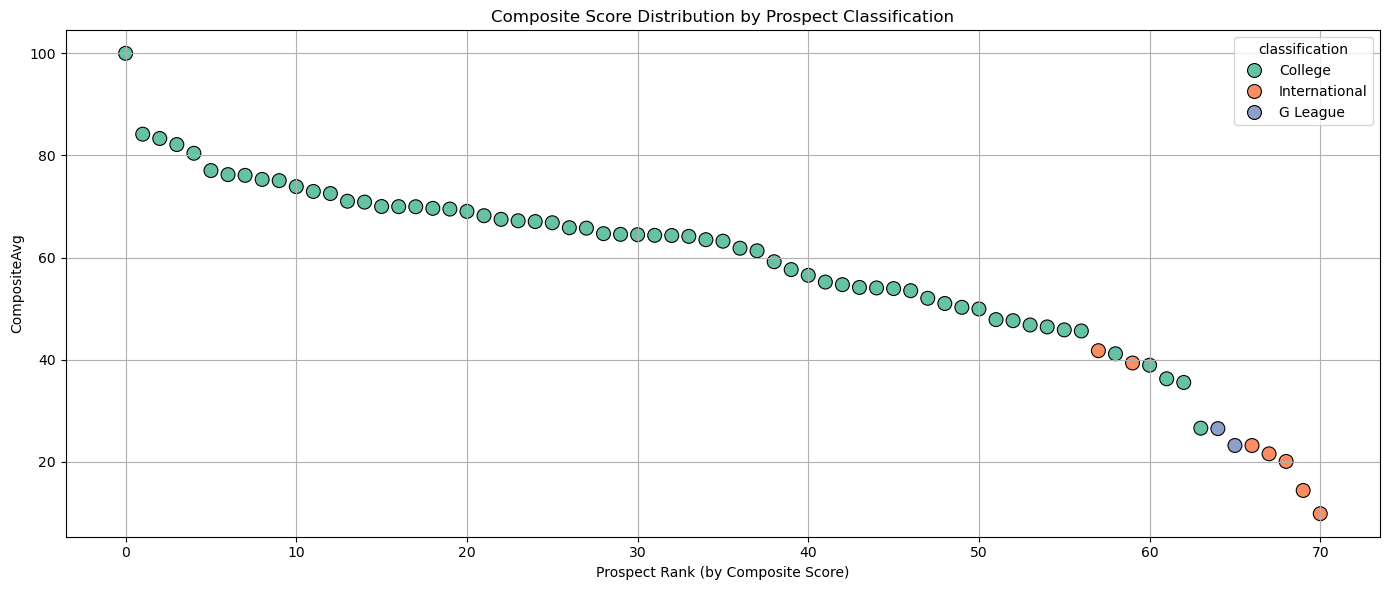

✅ Draft Accuracy (Team Match): 7.14%
🎯 Lottery Hit Rate: 14.29%


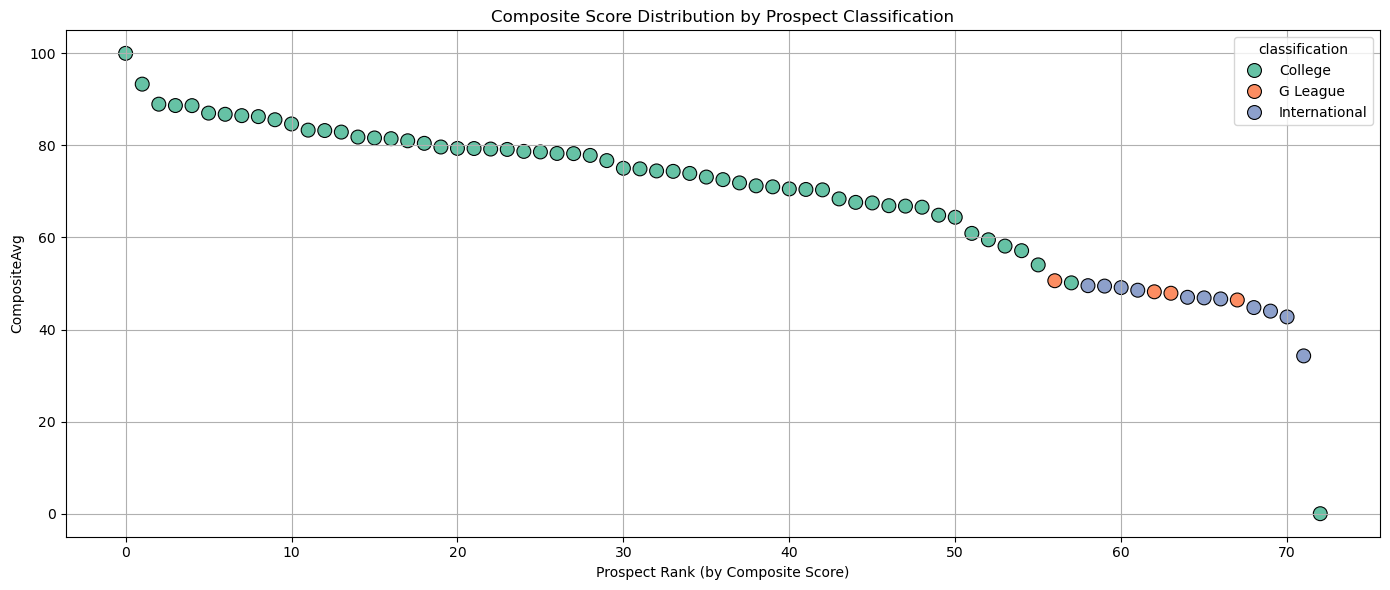

✅ Draft Accuracy (Team Match): 0.00%
🎯 Lottery Hit Rate: 28.57%


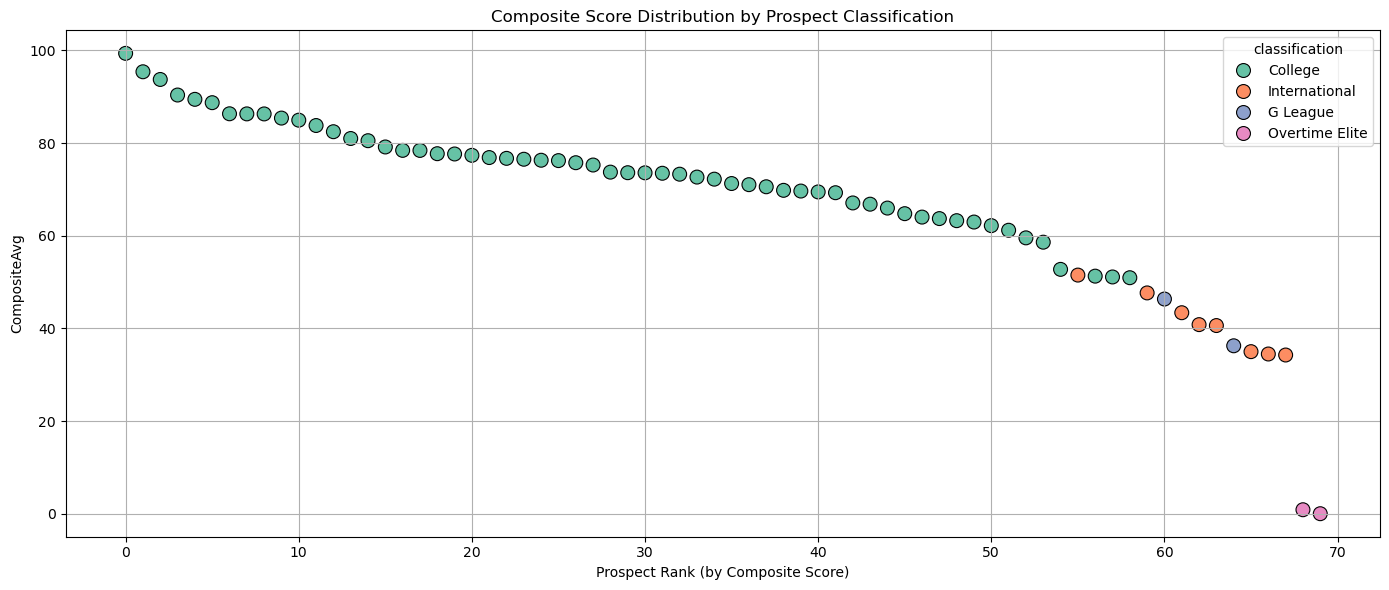

✅ Draft Accuracy (Team Match): 0.00%
🎯 Lottery Hit Rate: 7.14%


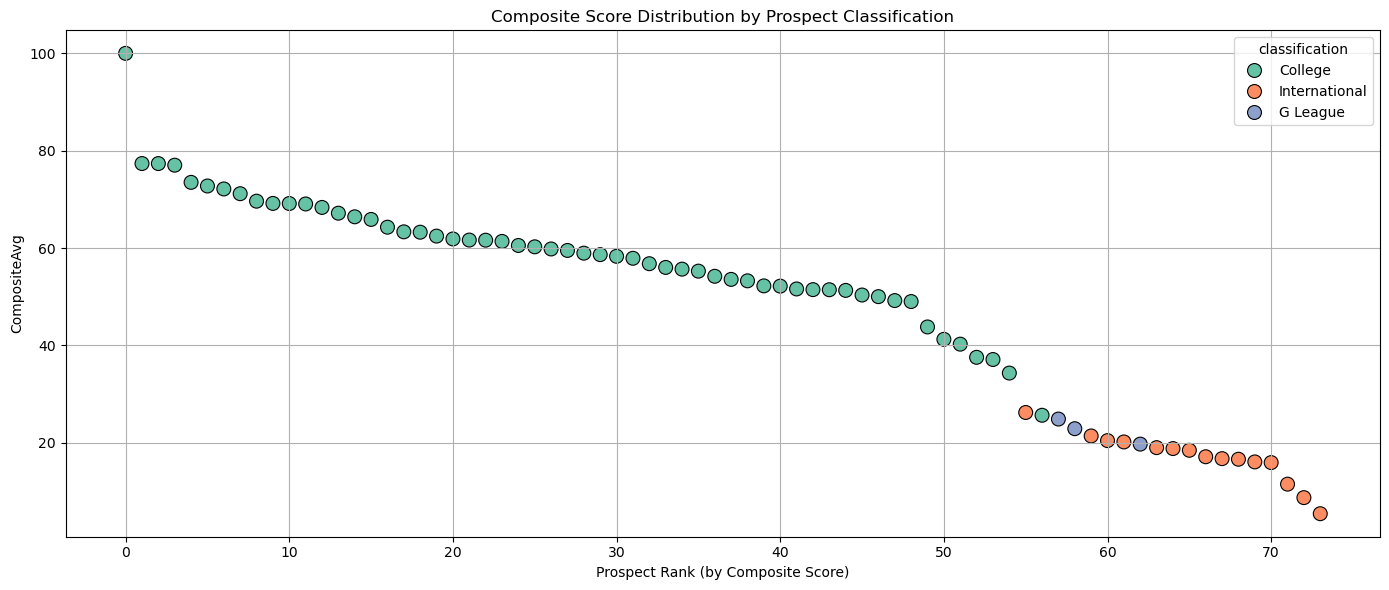

✅ Draft Accuracy (Team Match): 7.14%
🎯 Lottery Hit Rate: 21.43%


In [14]:
for year in training_years:
    simulate_draft(year)

In [ ]:
simulate_draft(2024)